## Adding the required Libraries

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',None)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns

import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

import re
from collections import Counter
import datetime as dt

C:\Users\tejas\Anaconda4\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
#Reading the dataset
tweets = pd.read_csv(r'C:\Users\tejas\Desktop\final_kanye.csv')
tweets.head(10)

,date,username,to,replies,retweets,favorites,Text,geo,mentions,hashtags,id,permalink
0,06-07-2020 23:59,Mike20Tibbetts,NaN,1,0,0,Gold digger seems appropriate. #kanyeforpresid...,NaN,NaN,#kanyeforpresident #KanyeWest,1.280290e+18,https://twitter.com/Mike20Tibbetts/status/1280...
1,06-07-2020 23:59,Ariel1646121136,NaN,0,0,2,Vous voulez voir KANYE WEST président des État...,NaN,NaN,#kanyeforpresident #DonalTrump #KanyeWest #Kim...,1.280290e+18,https://twitter.com/Ariel1646121136/status/128...
2,06-07-2020 23:57,dying_sam,NaN,0,0,0,If you vote for #KanyeWest you dumb as helllll...,NaN,NaN,#KanyeWest,1.280290e+18,https://twitter.com/dying_sam/status/128028974...
3,06-07-2020 23:55,WeebWithACamera,NaN,1,0,2,This is your friendly reminder that #KanyeWest...,NaN,NaN,#KanyeWest,1.280290e+18,https://twitter.com/WeebWithACamera/status/128...
4,06-07-2020 23:55,BANGShowbiz,NaN,0,0,0,Kanye West is VERY SERIOUS about running for p...,NaN,@KanyeWest,#KanyeWest #Kanye2020 #KanyeWest2020 #Ye2020pic,1.280290e+18,https://twitter.com/BANGShowbiz/status/1280289...
5,06-07-2020 23:55,GraceShared,NaN,1,2,2,#KanyeWest clothing & sneaker brand #Yeezy rec...,NaN,NaN,#KanyeWest #Yeezy,1.280290e+18,https://twitter.com/GraceShared/status/1280289...
6,06-07-2020 23:55,ElliP859,NaN,1,0,1,MASK Track 3 It’s Different This Time Link in ...,NaN,NaN,#success #trending #hiphop #rap #beats #jayz #...,1.280290e+18,https://twitter.com/ElliP859/status/1280289202...
7,06-07-2020 23:54,JornolTalk40,ATrickledown,3,0,0,Been there coming back with the t-shirt. Let m...,NaN,NaN,#Kanye2020 #2020VISION #KanyeWest,1.280290e+18,https://twitter.com/JornolTalk40/status/128028...
8,06-07-2020 23:53,maut99,NaN,2,0,0,#trap #latino #producer #beatmaker #vendobeat ...,NaN,NaN,#trap #latino #producer #beatmaker #vendobeat ...,1.280290e+18,https://twitter.com/maut99/status/128028885392...
9,06-07-2020 23:53,Mikamymeika1,NaN,1,0,0,"Hey USA, how about you guys vote for someone w...",NaN,NaN,#KanyeWest #DonaldTrump #VoteTrumpOut,1.280290e+18,https://twitter.com/Mikamymeika1/status/128028...


In [4]:
tweets.shape

(27010, 12)

Our dataset contains <b>27010 rows and 12 columns.

In [5]:
tweets.describe()

,replies,retweets,favorites,geo,id
count,27010.000000,27010.000000,27010.000000,0.0,2.701000e+04
mean,0.624917,1.436838,7.612921,NaN,1.280210e+18
std,8.318151,39.498163,175.953830,NaN,1.803547e+15
min,0.000000,0.000000,0.000000,NaN,1.279580e+18
25%,0.000000,0.000000,0.000000,NaN,1.279730e+18
50%,0.000000,0.000000,0.000000,NaN,1.280000e+18
75%,0.000000,0.000000,2.000000,NaN,1.280000e+18
max,942.000000,5055.000000,22697.000000,NaN,1.290000e+18


In [6]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27010 entries, 0 to 27009
Data columns (total 12 columns):
date         27010 non-null object
username     27010 non-null object
to           6820 non-null object
replies      27010 non-null int64
retweets     27010 non-null int64
favorites    27010 non-null int64
Text         27010 non-null object
geo          0 non-null float64
mentions     4747 non-null object
hashtags     27010 non-null object
id           27010 non-null float64
permalink    27010 non-null object
dtypes: float64(2), int64(3), object(7)
memory usage: 2.5+ MB


The <b>info</b> function gives us the description of each columns in our dataset - the datatype and the number of non-null values.

## Data Preparation and Preprocessing

After we extract the raw tweets, the data/tweets contains many <i>unnecessary letters and characters</i> which needs to be removed before we perform the sentiment analysis and build the model. 

After carefully analysing the dataset, we find that some of the tweets have been repeated or are a retweet of the original tweet. <u>These duplicate tweets might interfere in our model and sentiment analysis, hence we need to remove it.

In [10]:
#Checking the duplicate tweets by converting the tweets into a set.
tweets_set=set(tweets.Text)
print(len(tweets_set))
print("Duplicate Tweet Count:", len(tweets.Text)-len(tweets_set))

24531
Duplicate Tweet Count: 2479


Our dateset has been reduced from <b>27010 rows</b> to <b>24531 rows</b>. The count of the duplicate tweets is <b>2479.

In [75]:
#Removing the dulipacte tweets
kanye_original = tweets.drop_duplicates(subset = 'Text', keep = 'first')
kanye_original.shape
kanye = pd.DataFrame(kanye_original.Text)

After removing the duplicate tweets from our dataset, we will be cleaning our data ie.-removing the punctuations, numbers, URLs and emojis using the <b>Regex (Regular expressions).

In [76]:
#Removing URLs 
kanye.Text = [re.sub(r'http\S+',"", i) for i in kanye.Text]
kanye.Text = [re.sub(r'com',"",i) for i in kanye.Text]

#Removing the retweet text 'RT'.
kanye.Text = [re.sub('^RT[\s]','',i) for i in kanye.Text]

#Removing the hashtag symbol '#'.
kanye.Text = [re.sub('^#[\s]','',i) for i in kanye.Text]

#Removing all punctuations and numbers
kanye.Text = [re.sub('[^a-zA-Z]', ' ',i) for i in kanye.Text]

#Converting into lower case 
kanye.Text = [low.lower() for low in kanye.Text]

#Removing Emojis
def preprocess(Text):
    emojis = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',Text)
    Text = re.sub('[\W]+',' ', Text.lower()) +\
    ' '.join(emojis).replace('-','')
     
    return Text
    
kanye.Text = kanye.Text.apply(preprocess)


kanye.Text.head()

0    gold digger seems appropriate kanyeforpresiden...
1    vous voulez voir kanye west pr sident des tats...
2    if you vote for kanyewest you dumb as hellllll...
3    this is your friendly reminder that kanyewest ...
4    kanye west is very serious about running for p...
Name: Text, dtype: object

After removing the unnecessary characters from our tweets,we now need to remove the redundant words, known as <b>stopwords.</b> <i><u>Stopwords are the words that occur frequently in the text and are not considered informative.</i> These words are removed before the model is built. Lets check the stopwords present in the English language. 

In [77]:
#Checking the stopwords list
cachedStopWords=set(stopwords.words("english"))
print(cachedStopWords)

{'all', 'to', 'here', 'why', 'few', 'yours', 'he', 'wouldn', 'was', "mustn't", 'can', 'doing', 'below', 'by', 'again', 'if', 'ain', 'weren', 'theirs', "doesn't", 'it', 'through', 'than', 'didn', "she's", 'd', 'shouldn', 'their', 'we', 'whom', "isn't", 'during', 'my', 'being', 'herself', 'is', 's', 'ours', 'against', 're', 'after', "weren't", 'be', 'yourself', 'most', 'while', 'such', 'll', 'an', 'up', 'this', 'm', 'that', 'and', 'under', "don't", 'am', "shan't", 'i', 'don', 'doesn', 'isn', 'only', 'have', 'from', 'aren', 'because', 'over', 'your', "hasn't", "that'll", 'with', 'mightn', 'them', 'but', 'has', 'its', 'she', 'were', 'just', 'itself', 'about', 'needn', 'you', "it's", "wouldn't", 'between', 'hasn', 'how', 'a', 'wasn', 'in', 'own', 'yourselves', 'for', 'as', 'of', 'off', 'does', 'at', "you'll", 'now', 'are', 'ourselves', 'him', 'what', 'haven', 'did', 'couldn', 'above', 'on', 'her', "you'd", 'hadn', "aren't", "shouldn't", 'his', 'until', 'me', 'into', 've', 'himself', 'these'

In [78]:
#Removing Stop Words
kanye.Text=kanye.Text.apply(lambda tweet: ' '.join([word for word in tweet.split() if word not in cachedStopWords]))

After removing the stopwords we will be performing <b>Stemming</b> and <b>Lemmatizations</b>.

<b>Stemming</b> can defined as the <u>process of reducing inflected (derived) words to their word stem, base or root form—generally a written word form.

In [82]:
#Stemming
porter = PorterStemmer()
def stemWords(word):
    return porter.stem(word)
        
kanye["Text"] = kanye["Text"].apply(lambda tweet: ' '.join([stemWords(word) for word in tweet.split()]))

<b>Lemmatization</b> is defined as <u>the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form.

In [80]:
#Lemmatization: 
lema = WordNetLemmatizer()
def lemmatizeWords(word):
    return lema.lemmatize(word)
kanye.Text = kanye.Text.apply(lambda tweet: ' '.join([lemmatizeWords(word) for word in tweet.split()]))


Now that our data is cleaned and preprocessed, we can now perform the sentiment analysis and build the model.

## Sentiment Analysis

For performing the sentiment analysis, we will be using the <b>TextBlob</b> package and the <b>VADER Sentiment Analyser.

In [198]:
pol = []
for i in kanye.Text:
    blob = TextBlob(i) #Using the TextBlob
    pol.append(blob.sentiment.polarity)

In [56]:
#Adding polarity to the dataframe
kanye['Polarity']=pol
kanye.head()

,Text,Polarity
0,gold digger seem appropri kanyeforpresid kanye...,0.000
1,vou voulez voir kany west pr sident de tat uni...,0.000
2,vote kanyewest dumb hellllll boi,-0.375
3,friendli remind kanyewest go divid voter ensur...,0.400
4,kany west seriou run presid kanyewest kanyewes...,0.000


Lets count the number of tweets as per the polarity of the tweets. We will group the tweets as positive, negative and neutral tweets.

In [58]:
#Counting the number of tweets based on the polarity
positive=0
negative=0
neutral=0
sent=[]

for i in pol:
    if i>=0.2:
        positive+=1
        sent.append('Positive')
    elif i<=0:
        negative+=1
        sent.append('Negative')
    else:
        neutral+=1
        sent.append('Neutral')
print("Positive Tweets:",positive)
print("Negative Tweets:",negative)
print("Neutral Tweets:",neutral)

kanye['Sentiment']=sent
kanye.head()

Positive Tweets: 5569
Negative Tweets: 17123
Neutral Tweets: 1839


,Text,Polarity,Sentiment
0,gold digger seem appropri kanyeforpresid kanye...,0.000,Negative
1,vou voulez voir kany west pr sident de tat uni...,0.000,Negative
2,vote kanyewest dumb hellllll boi,-0.375,Negative
3,friendli remind kanyewest go divid voter ensur...,0.400,Positive
4,kany west seriou run presid kanyewest kanyewes...,0.000,Negative


After dividing the tweets into the groups mentioned above, we find that the majority of the tweets are off negative sentiment(17123 tweets). 

In [84]:
#Preparing words by splitting the tweets
words=[]
words=[word for tweet in kanye.Text for word in tweet.split()]

Now we will use the <b>VADER Sentiment Analyser</b> to get the polarity of the tweets.

In [60]:
import nltk
nltk.download('vader_lexicon') 

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tejas\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [199]:
#Using the VADER Sentiment Analyzer
sid = SentimentIntensityAnalyzer()
sentiment_scores = kanye.Text.apply(lambda x: sid.polarity_scores(x))
sentimental_score = pd.DataFrame(list(sentiment_scores))
sentimental_score.tail()

,neg,neu,pos,compound
24526,0.0,1.0,0.0,0.0
24527,0.0,1.0,0.0,0.0
24528,0.0,1.0,0.0,0.0
24529,0.0,1.0,0.0,0.0
24530,0.0,1.0,0.0,0.0


Lets divide the tweets into the following groups and assign the overall sentiment of the tweet.

In [201]:
sentimental_score['Sentiment'] = sentimental_score['compound'].apply(lambda x: 'negative' if x <= 0 else ('positive' if x >=0.2 else 'neutral'))
sentimental_score.head()

,neg,neu,pos,compound,Sentiment
0,0.000,1.000,0.000,0.0000,negative
1,0.000,1.000,0.000,0.0000,negative
2,0.452,0.548,0.000,-0.5106,negative
3,0.000,0.577,0.423,0.8750,positive
4,0.000,1.000,0.000,0.0000,negative


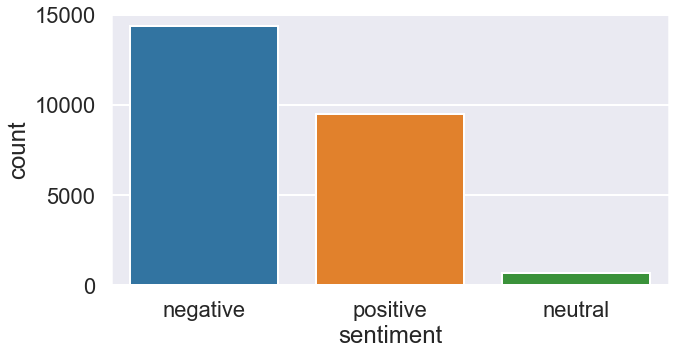

In [203]:
#Checking the number of tweets per sentiment
sns.set_style(style='darkgrid')
sns.set_context('poster')
fig= plt.figure(figsize=(10,5))
sent_count = pd.DataFrame.from_dict(Counter(sentimental_score['Sentiment']), orient = 'index').reset_index()
sent_count.columns = ['sentiment', 'count']

sns.barplot(y="count", x='sentiment', data=sent_count)

### WordCloud



Wordcloud is an image that comprises of words with different sizes and colors. The size of the words gives frequency of the word -<i><u>more frequent the words is, the bigger and bolder it will appear on the WordCloud.

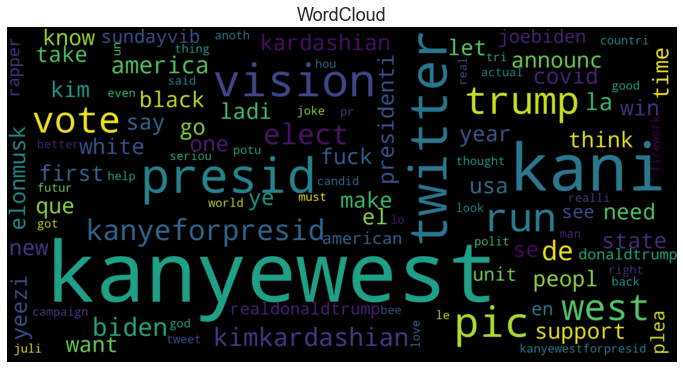

In [417]:
wordcloud=WordCloud(background_color='black',max_words=100,max_font_size=50,scale=5,collocations=False,
                      normalize_plurals=True).generate(' '.join(words))
    
plt.figure(figsize = (12, 12), facecolor="None") 
plt.imshow(wordcloud,interpolation='bilinear') 
plt.axis("off") 
plt.title("WordCloud",fontsize=18)
plt.show()

Now we will count the frequency of the words used in the tweets. For our analysis, we will observe the <u>first 60 most frequent words. 

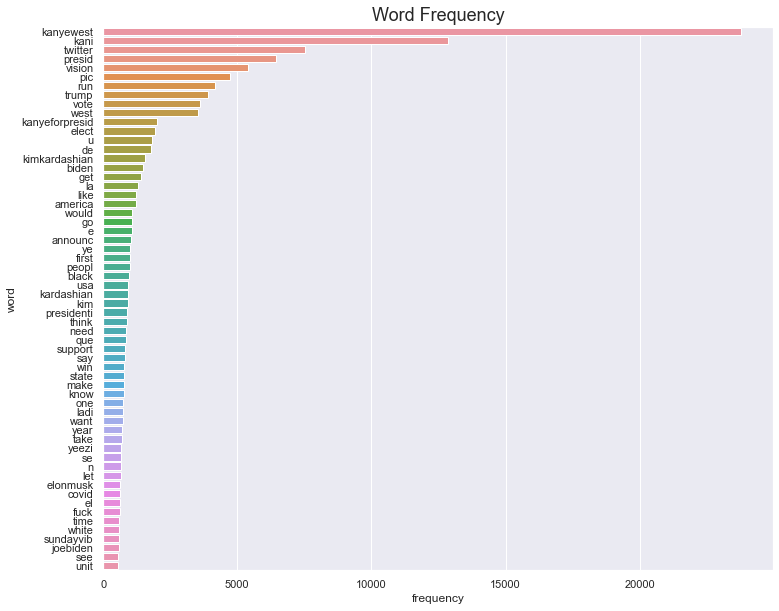

In [385]:
sns.set(style="darkgrid")
sns.set_context('notebook')
#Counting the word frequency of the tweets
counts = Counter(words).most_common(60)
counts_df = pd.DataFrame(counts)
counts_df.columns = ['word', 'frequency']
fig = plt.subplots(figsize = (12, 10))
plt.title("Word Frequency",fontsize=18)
sns.barplot(y="word", x='frequency', data=counts_df)

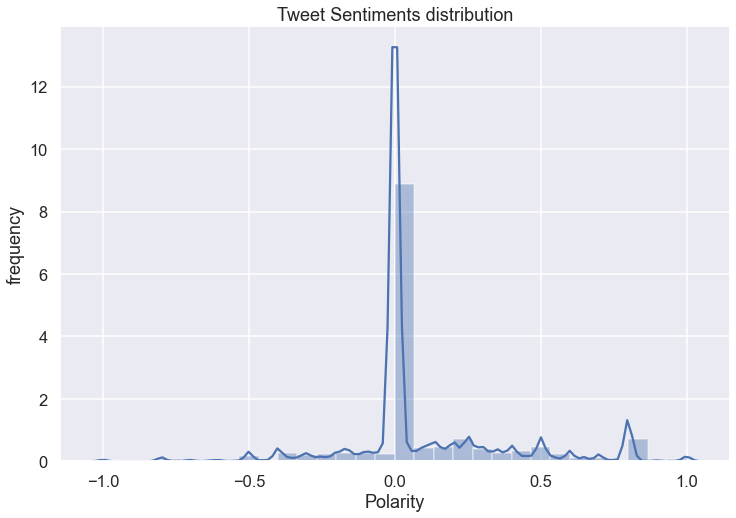

In [386]:
#Finding the frequency of the polarity
sns.set_context('talk')
fig,ax = plt.subplots(figsize = (12, 8))
ax.set(title='Tweet Sentiments distribution', xlabel='polarity', ylabel='frequency')
sns.distplot(kanye['Polarity'], bins=30)

This plot gives the distibution of the polarity of the tweets with a majority tweets either of neutral polarity or slightly of positive polarity.

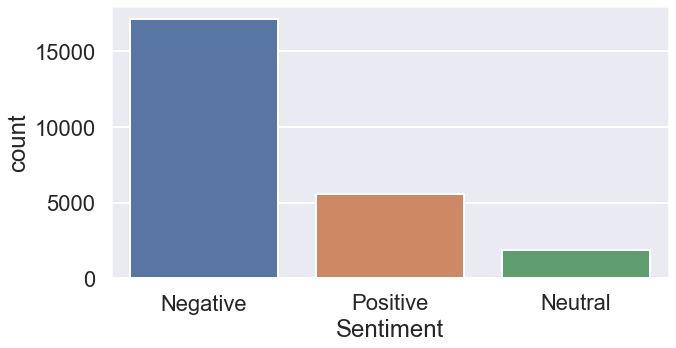

In [387]:
#Counting the number of different tweets
sns.set_style(style='darkgrid')
sns.set_context('poster')
fig= plt.figure(figsize=(10,5))
sns.countplot(kanye.Sentiment)

As we can see, majority of the tweets are of negative sentiment.

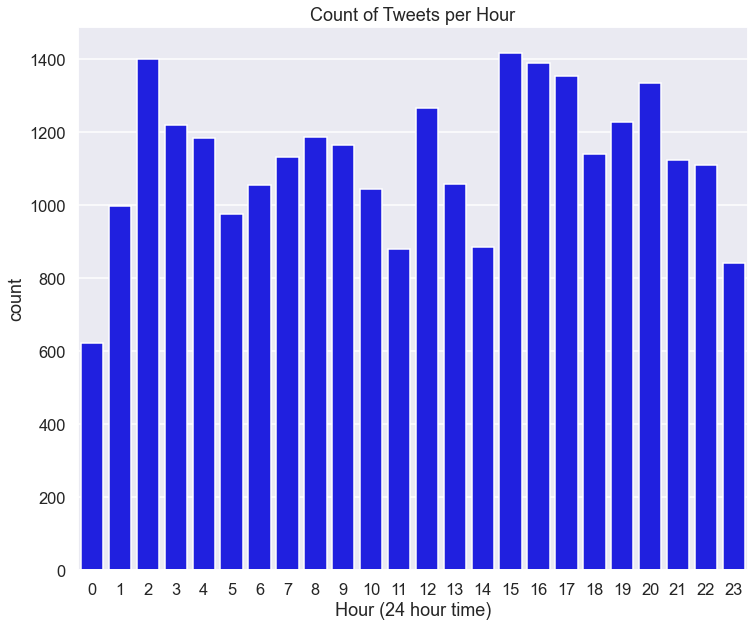

In [206]:
#Counting the number of tweets per hour
tweets['date'] = pd.to_datetime(tweets['date'])
hour = list(tweets.date.dt.hour)
count_hours=Counter(hour)
sns.set_context("talk")
fig,ax=plt.subplots(figsize=(12,10))
ax.set(title='Count of Tweets per Hour', xlabel='Hour (24 hour time)', ylabel='count')
sns.barplot(x=list(count_hours.keys()),y=list(count_hours.values()),color='blue')

The above tweets gives us the number of tweets per hour.

## Model Prediction

### Required Libraries

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import model_selection 


Before we can build the model, we need to transform the text data into the numerical features as we cannot directly feed the model the raw data.

We can convert the text document into the numerical representation by vectorization.
 

### TfiDF Vectorizer

<b>TfiDF Vectorizer</b> is a method to transforms text to feature vectors that can be used <u>to evaluate how important a word is to a document in a collection or corpus.</u>

It is termed as the <b>Term Frequency Inverse Document Frequency</b>.<ul>   
    
    1.Term Frequency: The number of times the particular word appears in a single document.
    2.Inverse Document Frequency:The log ratio of the total number of documents divided by the total documents where that particular word appears.
   
Hence the TfiDf can be calculated by:<l>
    
    TfiDF = Tf * iDf
    
    

In [61]:
#Definining the vectorizer
vect = TfidfVectorizer(ngram_range=(1,1), max_features=100,smooth_idf=True,use_idf=True).fit(kanye.Text)

#Transform the vectorizer
X_txt = vect.transform(kanye.Text)

#Transforming to a data frame
X_df=pd.DataFrame(X_txt.toarray(), columns=vect.get_feature_names())
X_df.head(10)

,actual,america,american,announc,anoth,bee,better,biden,black,campaign,candid,could,countri,covid,de,donaldtrump,el,elect,elonmusk,en,even,first,fuck,futur,get,go,god,good,got,help,hous,joebiden,joke,kany,kanyeforpresid,kanyewest,kanyewestforpresid,kardashian,kim,kimkardashian,know,la,ladi,le,let,like,lo,look,love,make,man,must,need,new,news,one,peopl,pic,plea,polit,potu,pr,presid,president,presidenti,que,rapper,realdonaldtrump,realli,right,run,said,say,se,see,state,sundayvib,support,take,thing,think,thought,time,trump,tweet,twitter,un,unit,usa,vision,vote,want,west,white,win,world,would,ye,year,yeezi
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.949038,0.315160,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0000,0.000000
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.27507,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.130705,0.241501,0.080198,0.0,0.0,0.0,0.257673,0.0,0.0,0.0,0.689694,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.342399,0.000000,0.0,0.0,0.316054,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.204733,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.203427,0.0,0.000000,0.0,0.0,0.000000,0.0000,0.000000
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.347715,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.937600,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0000,0.000000
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.282446,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.362306,0.0,0.0,0.0,0.000000,0.301266,0.0,0.0,0.0,0.00000,0.0,0.0,0.354213,0.138626,0.000000,0.085059,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.584618,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.217141,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.229358,0.0,0.000000,0.0,0.323644,0.0,0.0,0.000000,0.0000,0.000000
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.428187,0.000000,0.394093,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.293434,0.0,0.0,0.0,0.000000,0.277942,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.313909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.244225,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.333212,0.0,0.000000,0.0,0.0,0.478306,0.0000,0.000000
5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.241297,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0000,0.970451
6,0.000000,0.0,0.0,

The <b>LabelEncoder</b> to convert the categorical features into numerical features. We will use it to the Sentiment column.

In [62]:
X_df['Sentiment'] = sent
label = LabelEncoder()
X_df['Label'] = label.fit_transform(X_df['Sentiment'])

X_df.head()

,actual,america,american,announc,anoth,bee,better,biden,black,campaign,candid,could,countri,covid,de,donaldtrump,el,elect,elonmusk,en,even,first,fuck,futur,get,go,god,good,got,help,hous,joebiden,joke,kany,kanyeforpresid,kanyewest,kanyewestforpresid,kardashian,kim,kimkardashian,know,la,ladi,le,let,like,lo,look,love,make,man,must,need,new,news,one,peopl,pic,plea,polit,potu,pr,presid,president,presidenti,que,rapper,realdonaldtrump,realli,right,run,said,say,se,see,state,sundayvib,support,take,thing,think,thought,time,trump,tweet,twitter,un,unit,usa,vision,vote,want,west,white,win,world,would,ye,year,yeezi,Sentiment,Label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.949038,0.315160,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,Negative,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.27507,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.130705,0.241501,0.080198,0.0,0.0,0.0,0.257673,0.0,0.0,0.0,0.689694,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.342399,0.000000,0.0,0.0,0.316054,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.204733,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.203427,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,Negative,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.347715,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.937600,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,Negative,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.282446,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.362306,0.0,0.0,0.0,0.0,0.301266,0.0,0.0,0.0,0.0,0.0,0.0,0.354213,0.138626,0.000000,0.085059,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.584618,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217141,0.0,0.000000,0.0,0.0,0.0,0.0,0.229358,0.0,0.000000,0.0,0.323644,0.0,0.0,0.000000,0.0,0.0,Positive,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.428187,0.000000,0.394093,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.293434,0.0,0.0,0.0,0.000000,0.277942,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.313909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.244225,0.0,0.0,0.0,0.0,0.000000,0.0,0.333212,0.0,0.000000,0.0,0.0,0.478306,0.0,0.0,Negative,0


After converting the Sentiment column into the numerical values, we find that:<ul>
    
    Negative Sentiment-0
    Neutral Setiment-1
    Positive Sentiment-2

We have our target variable(Label) and the predictor variables. Now we will split our dataset into training and testing dataset, using the train_test_split method.

In [101]:
#Splitting the dataset into training and testing set 
X = X_df.drop(['Sentiment','Label'],axis=1)
y = X_df.Label

X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.2, random_state=0) #Testing dataset size-20% of the total 

## Naives Bayes

In [170]:
nb = MultinomialNB().fit(X_train, y_train) #Training the model

#Predicting the test set 
y_pred_nb= nb.predict(X_test)

In [171]:
#Checking the accuracy,precision,recall,f1 scores
accuracy_score_nb = accuracy_score(y_test, y_pred_nb)
precision_score_nb = precision_score(y_test, y_pred_nb , average = 'micro')
recall_score_nb = recall_score(y_test, y_pred_nb , average = 'micro')
f1_score_nb = f1_score(y_test, y_pred_nb , average = 'micro')
print("Accuracy Score: " , accuracy_score_nb)

print("Precision Score: " , precision_score_nb)
print("Recall Score: " , recall_score_nb)
print("F1 Score: " , f1_score_nb)
print("Classification Report:\n",classification_report(y_test, y_pred_nb))

Accuracy Score:  0.8416547788873039
Precision Score:  0.8416547788873039
Recall Score:  0.8416547788873039
F1 Score:  0.8416547788873039
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.99      0.91      3443
           1       0.67      0.08      0.15       341
           2       0.84      0.63      0.72      1123

    accuracy                           0.84      4907
   macro avg       0.78      0.57      0.59      4907
weighted avg       0.83      0.84      0.81      4907



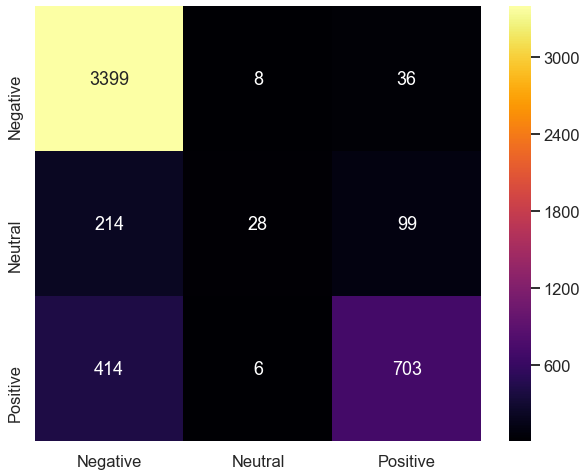

In [194]:
#Constructing a confusion matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)
df_cm_nb = pd.DataFrame(cm_nb)
categories = ['Negative','Neutral','Positive']
plt.figure(figsize=(10,8))
sns.heatmap(df_cm_nb, cmap='inferno' ,annot=True, annot_kws={"size": 18}, xticklabels = categories,
            yticklabels = categories,fmt="d")

### Hyperparameter Optimization

In [154]:
#Getting the parameters of the particular model 
nb.get_params().keys()

dict_keys(['alpha', 'class_prior', 'fit_prior'])

In [204]:
NB_opti = MultinomialNB() #Using the MultinomialNB
param_grid = {'alpha':[1,2,3,4], } #Selecting the parameters

In [156]:
model_NB = model_selection.GridSearchCV(estimator=NB_opti, #GridSearch
                                    param_grid=param_grid,
                                        cv=10)
model_NB.fit(X_train,y_train)
print(model_NB.best_score_) #Gives the best score of the model
print(model_NB.best_estimator_.get_params()) #Gives the best parameters of the model

0.8292388026606388
{'alpha': 1, 'class_prior': None, 'fit_prior': True}


## Decision Tree

In [168]:
DT = DecisionTreeClassifier().fit(X_train, y_train) #Training the model

#predicting the test set 
y_pred_dt= DT.predict(X_test)

In [158]:
#Checking the accuracy,precision,recall and f1 scores
accuracy_score_dt = accuracy_score(y_test, y_pred_dt)
precision_score_dt = precision_score(y_test, y_pred_dt , average = 'micro')
recall_score_dt = recall_score(y_test, y_pred_dt , average = 'micro')
f1_score_dt = f1_score(y_test, y_pred_dt , average = 'micro')

print("Accuracy Score: " , accuracy_score_dt)
print("Precision Score: " , precision_score_dt)
print("Recall Score: " , recall_score_dt)
print("F1 Score: " , f1_score_dt)
print("Classification Report:\n",classification_report(y_test, y_pred_dt))

Accuracy Score:  0.7976360301609945
Precision Score:  0.7976360301609945
Recall Score:  0.7976360301609945
F1 Score:  0.7976360301609945
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89      3443
           1       0.30      0.26      0.28       341
           2       0.69      0.63      0.66      1123

    accuracy                           0.80      4907
   macro avg       0.62      0.60      0.61      4907
weighted avg       0.79      0.80      0.79      4907



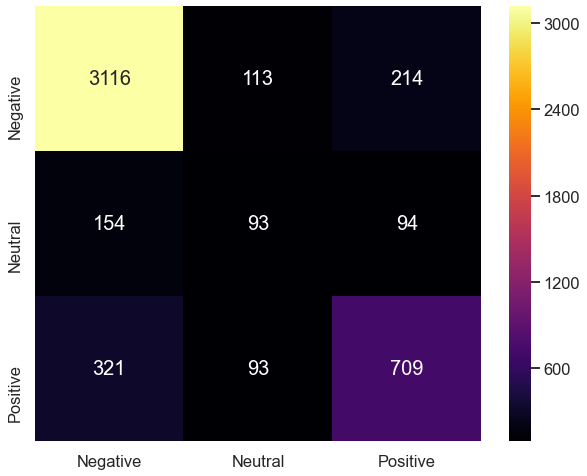

In [195]:
#Construting the confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
df_cm_dt = pd.DataFrame(cm_dt)
categories = ['Negative','Neutral','Positive']
plt.figure(figsize=(10,8))
sns.heatmap(df_cm_dt, cmap='inferno' ,annot=True, annot_kws={"size": 20}, xticklabels = categories,
            yticklabels = categories,fmt="d")

### Hyperparamter Optimization

In [160]:
#Getting the parameters of the particular model 
DT.get_params().keys() 

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [186]:
DT_opti = DecisionTreeClassifier() 

param_grid = {"max_depth" : [1,3,5,7],     #Setting the parameters for the model
               "criterion" : ["gini","entropy"],
              "min_samples_split" : [2,3,4],
              "max_leaf_nodes" : [7,8,9],
              "min_samples_leaf": [2,3,4],
}


In [190]:
model_DT = model_selection.GridSearchCV(estimator=DT_opti, #GridSearch
                                    param_grid=param_grid, 
                                        cv=10)
model_DT.fit(X_train,y_train)
print(model_DT.best_score_) #Gives the best score of the model
print(model_DT.best_estimator_.get_params()) #Gives the best parameters

0.8312774867152412
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'max_leaf_nodes': 9, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'best'}


## Random Forest

In [197]:
RF = RandomForestClassifier(n_jobs=1).fit(X_train, y_train) #Training the model

#Predicting the test set
y_pred_RF = RF.predict(X_test)

In [145]:
#Checking the accuracy,precision,recall and f1 scores
accuracy_score_RF = accuracy_score(y_test, y_pred_RF)
precision_score_RF = precision_score(y_test, y_pred_RF , average = 'micro')
recall_score_RF = recall_score(y_test, y_pred_RF, average = 'micro')
f1_score_RF = f1_score(y_test, y_pred_RF, average = 'micro')

print("Accuracy Score: " , accuracy_score_RF)
print("Precision Score: " , precision_score_RF)
print("Recall Score: " , recall_score_RF)
print("F1 Score:" , f1_score_RF)
print("Classification Report:\n",classification_report(y_test, y_pred_RF))

Accuracy Score:  0.8528632565722437
Precision Score:  0.8528632565722437
Recall Score:  0.8528632565722437
F1 Score: 0.8528632565722437
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92      3443
           1       0.62      0.20      0.30       341
           2       0.83      0.67      0.74      1123

    accuracy                           0.85      4907
   macro avg       0.77      0.62      0.65      4907
weighted avg       0.84      0.85      0.83      4907



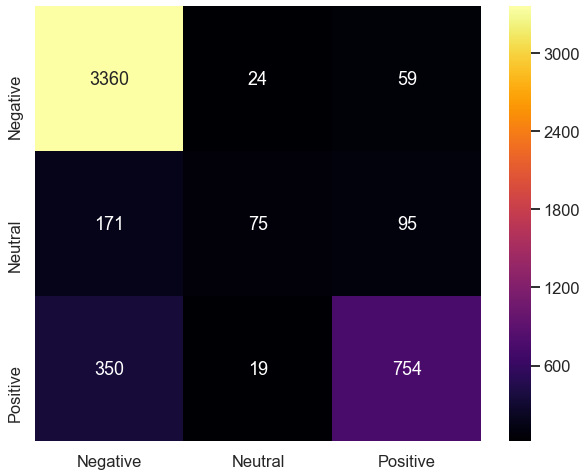

In [196]:
#Construting the confusion matrix
cm_RF = confusion_matrix(y_test, y_pred_RF)
df_cm_RF = pd.DataFrame(cm_RF)
categories = ['Negative','Neutral','Positive']
plt.figure(figsize=(10,8))
sns.heatmap(df_cm_RF, cmap='inferno' ,annot=True, annot_kws={"size": 18}, xticklabels = categories,
            yticklabels = categories,fmt="d")

### Hyperparameter Optimization

In [148]:
#Getting the parameters of the particular model 
RF.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [180]:
RF_opti1 = RandomForestClassifier()
param_grid = {"n_estimators": np.arange(100,1500,100), #Selecting the parameters
               "max_depth": np.arange(1,20),
               "criterion": ["gini","entropy"], 
              
              
             }

In [184]:
model_RF1 = model_selection.RandomizedSearchCV(estimator=RF_opti1, #RandomizedSearch
                                    param_distributions=param_grid,
                                    n_iter=10,
                                    scoring='accuracy',
                                    verbose=10,
                                    n_jobs=1,
                                    cv=5)
model_RF1.fit(X_train,y_train)
print(model_RF1.best_score_) #Gives the best score of the model
print(model_RF1.best_estimator_.get_params()) #Gives the best parameters of the model

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=1300, max_depth=15, criterion=entropy ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=1300, max_depth=15, criterion=entropy, score=0.846, total=  35.0s
[CV] n_estimators=1300, max_depth=15, criterion=entropy ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.9s remaining:    0.0s


[CV]  n_estimators=1300, max_depth=15, criterion=entropy, score=0.846, total=  34.9s
[CV] n_estimators=1300, max_depth=15, criterion=entropy ..............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


[CV]  n_estimators=1300, max_depth=15, criterion=entropy, score=0.838, total=  35.0s
[CV] n_estimators=1300, max_depth=15, criterion=entropy ..............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.7min remaining:    0.0s


[CV]  n_estimators=1300, max_depth=15, criterion=entropy, score=0.844, total=  34.9s
[CV] n_estimators=1300, max_depth=15, criterion=entropy ..............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.3min remaining:    0.0s


[CV]  n_estimators=1300, max_depth=15, criterion=entropy, score=0.844, total=  34.9s
[CV] n_estimators=1400, max_depth=8, criterion=entropy ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.9min remaining:    0.0s


[CV]  n_estimators=1400, max_depth=8, criterion=entropy, score=0.809, total=  23.4s
[CV] n_estimators=1400, max_depth=8, criterion=entropy ...............


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  3.3min remaining:    0.0s


[CV]  n_estimators=1400, max_depth=8, criterion=entropy, score=0.807, total=  23.3s
[CV] n_estimators=1400, max_depth=8, criterion=entropy ...............


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  3.7min remaining:    0.0s


[CV]  n_estimators=1400, max_depth=8, criterion=entropy, score=0.809, total=  23.2s
[CV] n_estimators=1400, max_depth=8, criterion=entropy ...............


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  4.1min remaining:    0.0s


[CV]  n_estimators=1400, max_depth=8, criterion=entropy, score=0.814, total=  23.1s
[CV] n_estimators=1400, max_depth=8, criterion=entropy ...............


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  4.5min remaining:    0.0s


[CV]  n_estimators=1400, max_depth=8, criterion=entropy, score=0.809, total=  23.0s
[CV] n_estimators=1200, max_depth=1, criterion=gini ..................
[CV]  n_estimators=1200, max_depth=1, criterion=gini, score=0.697, total=   4.8s
[CV] n_estimators=1200, max_depth=1, criterion=gini ..................
[CV]  n_estimators=1200, max_depth=1, criterion=gini, score=0.697, total=   5.4s
[CV] n_estimators=1200, max_depth=1, criterion=gini ..................
[CV]  n_estimators=1200, max_depth=1, criterion=gini, score=0.697, total=   5.2s
[CV] n_estimators=1200, max_depth=1, criterion=gini ..................
[CV]  n_estimators=1200, max_depth=1, criterion=gini, score=0.697, total=   5.6s
[CV] n_estimators=1200, max_depth=1, criterion=gini ..................
[CV]  n_estimators=1200, max_depth=1, criterion=gini, score=0.697, total=   5.2s
[CV] n_estimators=1200, max_depth=5, criterion=gini ..................
[CV]  n_estimators=1200, max_depth=5, criterion=gini, score=0.783, total=  12.0s
[CV]

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 10.7min finished


0.8446799509145094
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 18, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 400, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
